In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [2]:
# Load a dataset into a dataframe
df = pd.read_csv('Telco-Customer-Churn.csv')
df = df.drop(columns=['customerID'])
print(df.head())
df.shape


   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No  

(7043, 20)

In [3]:
df_columns = df.columns.tolist()
for column in df_columns:
    print(f"{column} unique values : {df[column].unique()}")

gender unique values : ['Female' 'Male']
SeniorCitizen unique values : [0 1]
Partner unique values : ['Yes' 'No']
Dependents unique values : ['No' 'Yes']
tenure unique values : [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
PhoneService unique values : ['No' 'Yes']
MultipleLines unique values : ['No phone service' 'No' 'Yes']
InternetService unique values : ['DSL' 'Fiber optic' 'No']
OnlineSecurity unique values : ['No' 'Yes' 'No internet service']
OnlineBackup unique values : ['Yes' 'No' 'No internet service']
DeviceProtection unique values : ['No' 'Yes' 'No internet service']
TechSupport unique values : ['No' 'Yes' 'No internet service']
StreamingTV unique values : ['No' 'Yes' 'No internet service']
StreamingMovies unique values : ['No' 'Yes' 'No internet service']
Contract unique values : ['Month-to-month' 'O

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [6]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [7]:
df["PaymentMethod"].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [8]:
#Delete (automatic) from PaymentMethod
df["PaymentMethod"] = df["PaymentMethod"].str.replace(" (automatic)", "", regex=False)

In [9]:
#Missing Values
features_na = [feature for feature in df.columns if df[feature].isnull().sum() > 1]

for feature in features_na:
    print(f"{feature}, {round(df[feature].isnull().mean(), 4)} % Missing Values")
    

TotalCharges, 0.0016 % Missing Values


In [10]:
#Check Missing Values
df[df[features_na[0]].isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer,52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card,56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
#Drop Missing Values
df.dropna(inplace=True)

In [12]:
#Visualization
plt.style.use("ggplot")

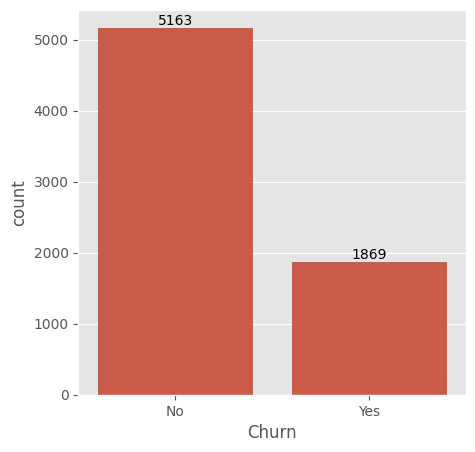

In [13]:
plt.figure(figsize=(5,5))
ax = sns.countplot(x = df["Churn"])
ax.bar_label(ax.containers[0])
plt.show()

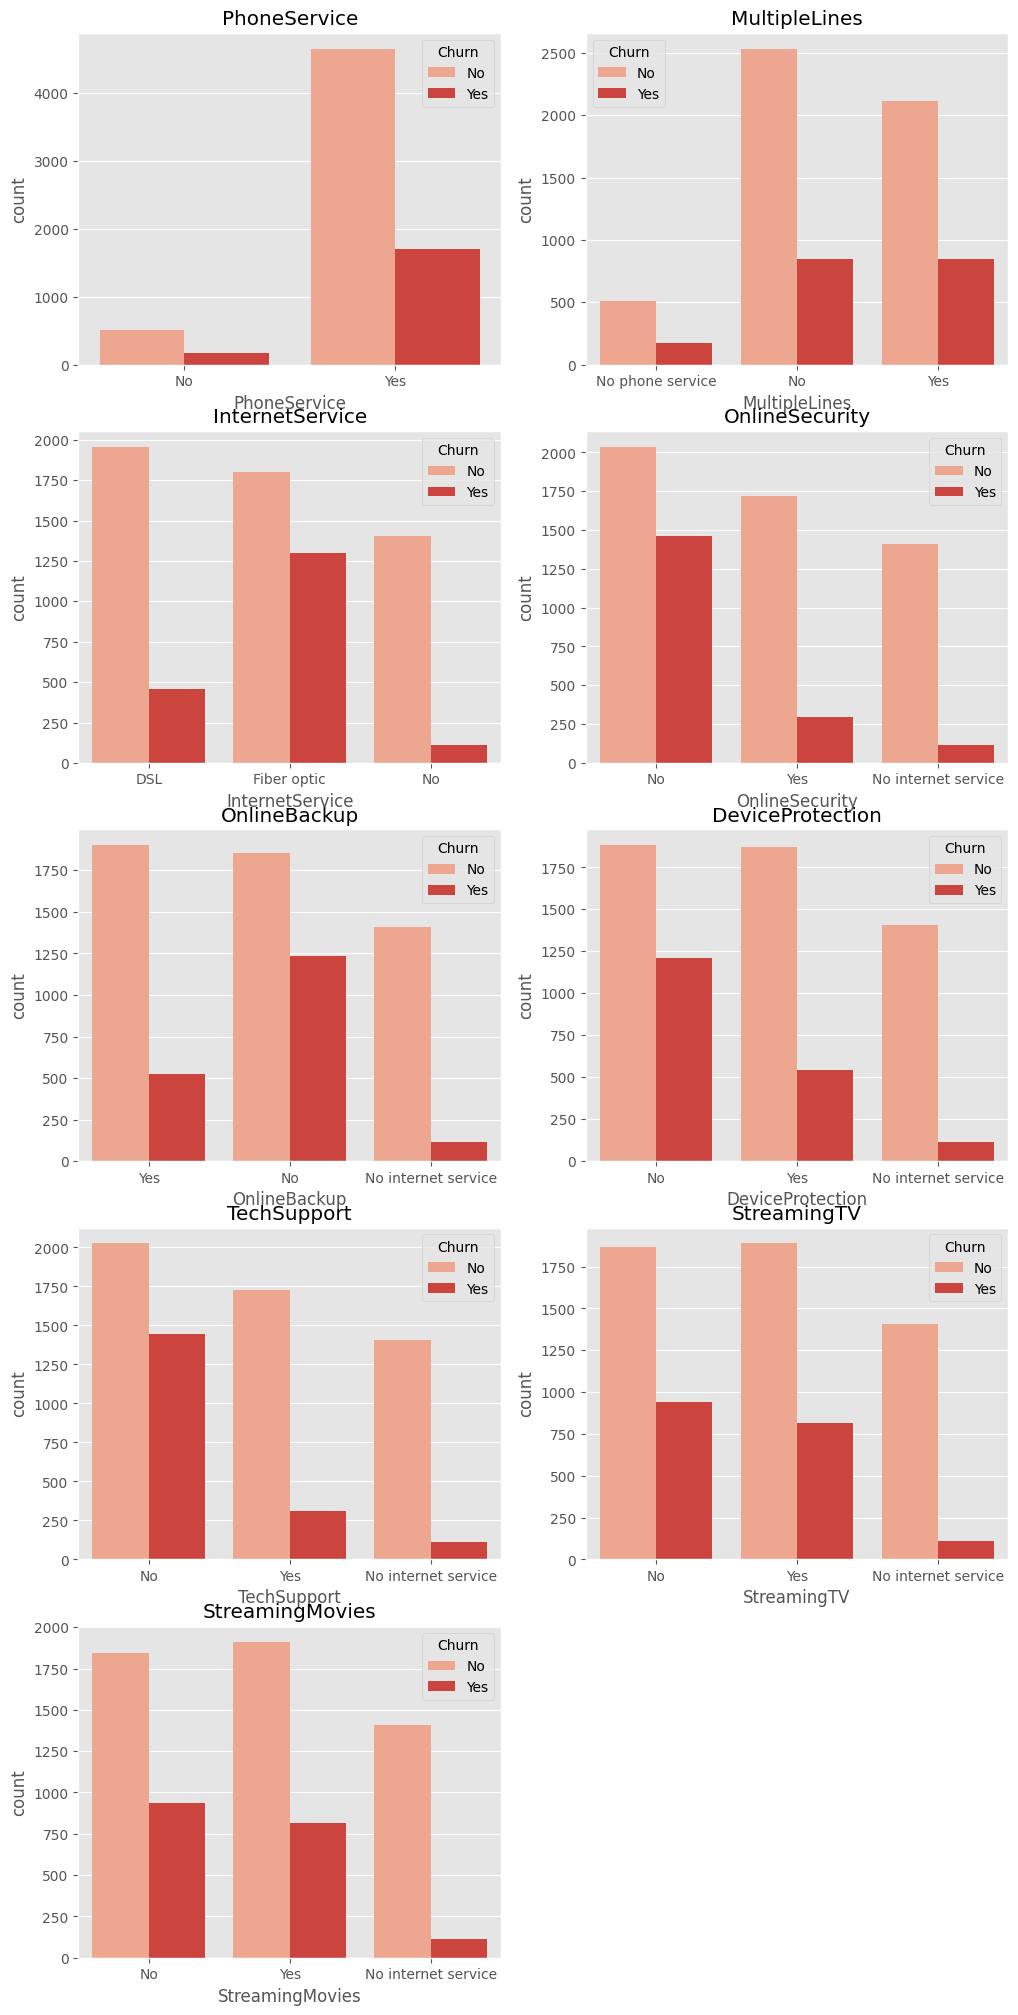

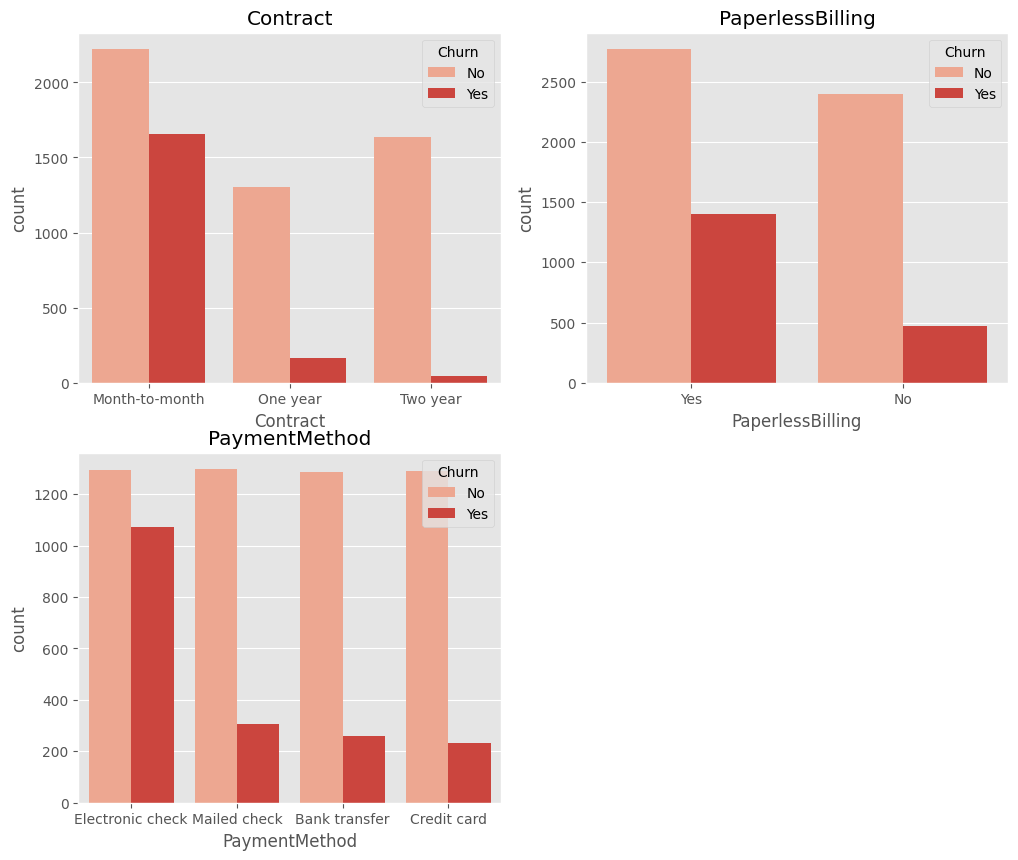

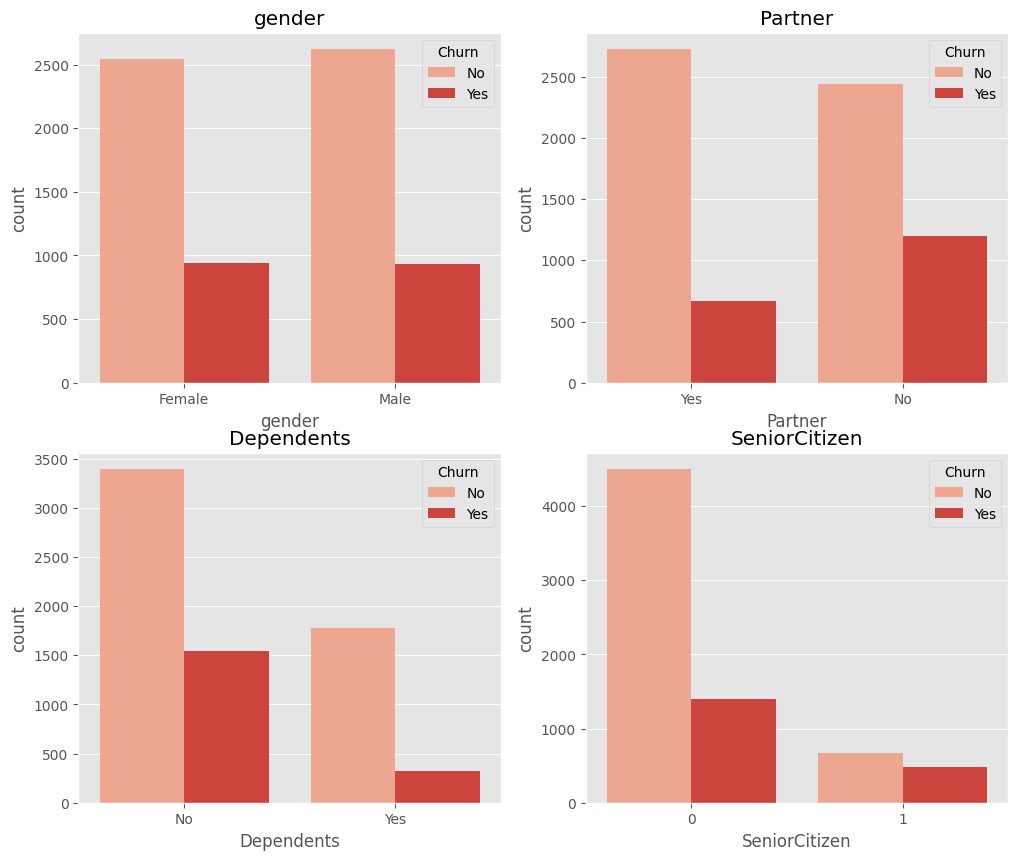

In [14]:
#Make a function to plot categorical data according to target
def plot_categorical_to_target(df,categorical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(categorical_values)/2)
    
    fig = plt.figure(figsize = (12, 5*number_of_rows))
    
    for index, column in enumerate(categorical_values, 1):
        ax = fig.add_subplot(number_of_rows,number_of_columns,index)
        ax = sns.countplot(x = column, data = df, hue = target, palette="Reds")
        ax.set_title(column)
    return plt.show()

customer_services = ["PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                    "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
plot_categorical_to_target(df,customer_services, "Churn")

customer_account_cat = ["Contract","PaperlessBilling","PaymentMethod"]
plot_categorical_to_target(df,customer_account_cat,"Churn")

customer_demographics = ["gender","Partner","Dependents","SeniorCitizen"]
plot_categorical_to_target(df,customer_demographics,"Churn")

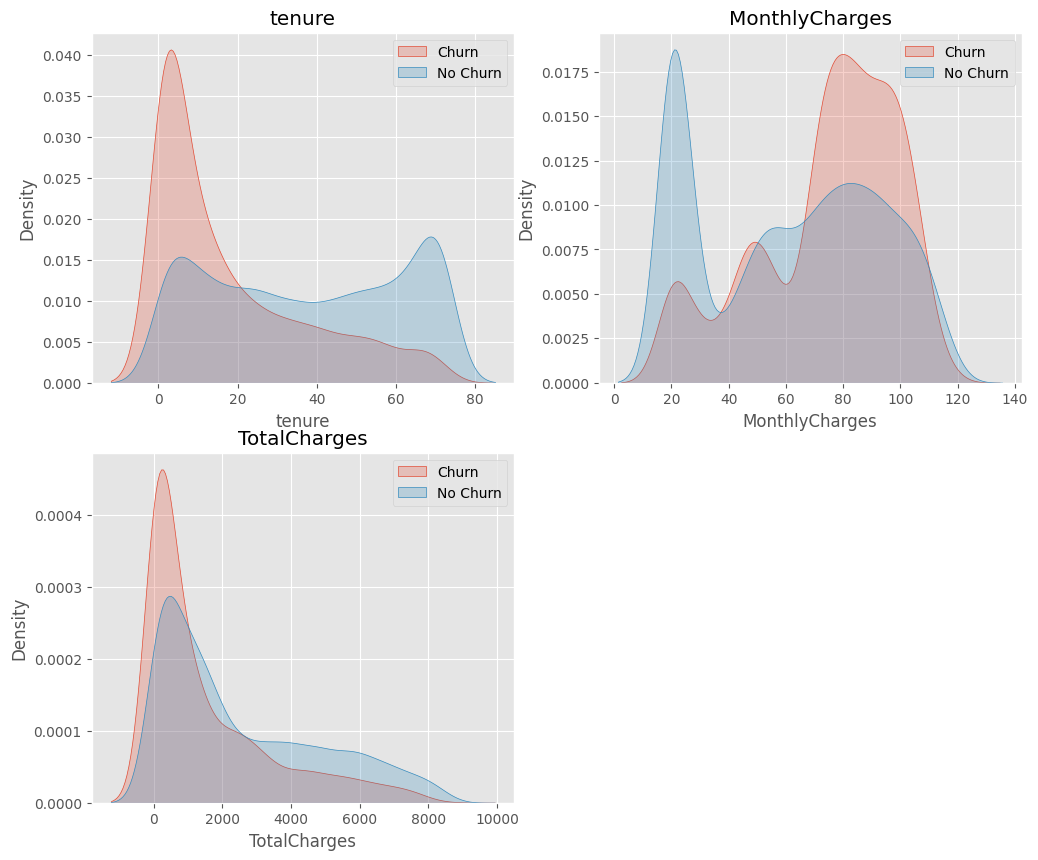

In [15]:
def histogram_plots(df, numerical_values, target):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    
    for index, column in enumerate(numerical_values,1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.kdeplot(df[column][df[target]=="Yes"] ,fill = True)
        ax = sns.kdeplot(df[column][df[target]=="No"], fill = True)
        ax.set_title(column)
        ax.legend(["Churn","No Churn"], loc='upper right')
    plt.savefig("numerical_variables.png", dpi=300)
    return plt.show()

customer_account_num = ["tenure", "MonthlyCharges","TotalCharges"]
histogram_plots(df,customer_account_num, "Churn")


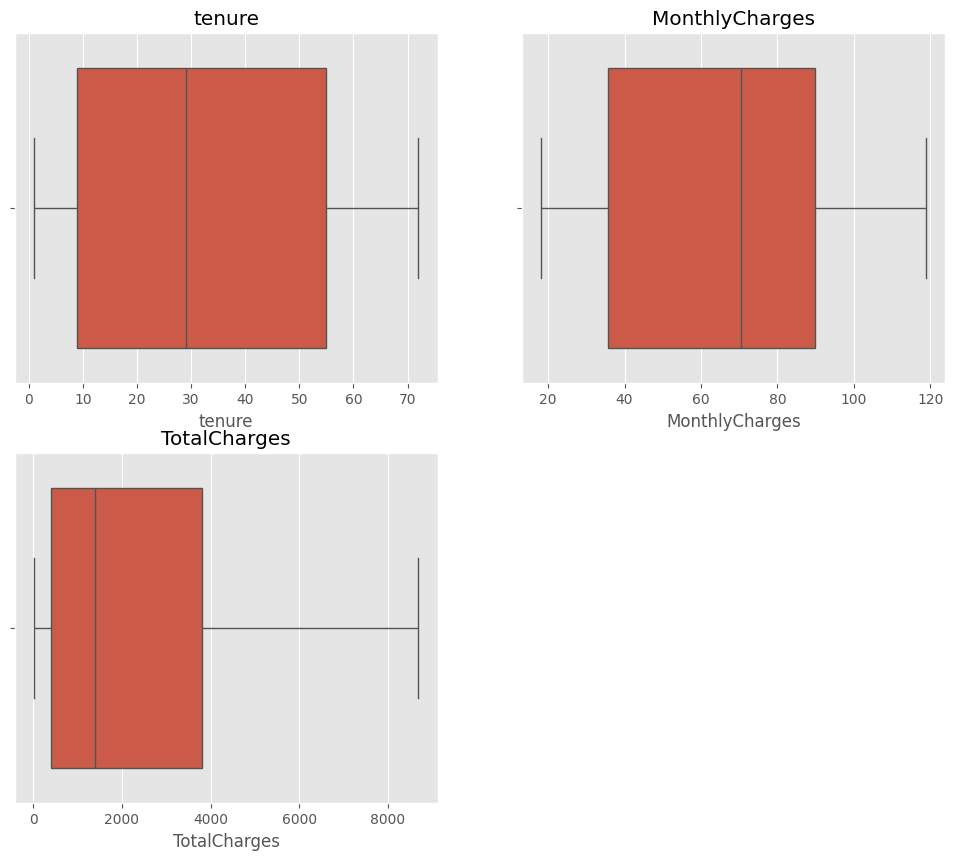

In [16]:
#Check for Outliers
def outlier_check_boxplot(df,numerical_values):
    number_of_columns = 2
    number_of_rows = math.ceil(len(numerical_values)/2)
    
    fig = plt.figure(figsize=(12,5*number_of_rows))
    for index, column in enumerate(numerical_values, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        ax = sns.boxplot(x = column, data = df)
        ax.set_title(column)
    plt.savefig("Outliers_check.png", dpi=300)
    return plt.show()

numerical_values = ["tenure","MonthlyCharges","TotalCharges"]
outlier_check_boxplot(df,numerical_values)

In [17]:
#Label Encoding 
feature_le = ["Partner","Dependents","PhoneService", "Churn","PaperlessBilling"]
def label_encoding(df,features):
    for i in features:
        df[i] = df[i].map({"Yes":1, "No":0})
    return df

df = label_encoding(df,feature_le)
df["gender"] = df["gender"].map({"Female":1, "Male":0})

In [18]:
#One Hot Encoding
features_ohe = ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                "DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]
df_ohe = pd.get_dummies(df, columns=features_ohe)

In [19]:
#Feature Scaling
features_mms = ["tenure","MonthlyCharges","TotalCharges"]

df_mms = pd.DataFrame(df_ohe, columns=features_mms)
df_remaining = df_ohe.drop(columns=features_mms)

mms = MinMaxScaler(feature_range=(0,1))
rescaled_feature = mms.fit_transform(df_mms)

rescaled_feature_df = pd.DataFrame(rescaled_feature, columns=features_mms, index=df_remaining.index)
df = pd.concat([rescaled_feature_df,df_remaining],axis=1)

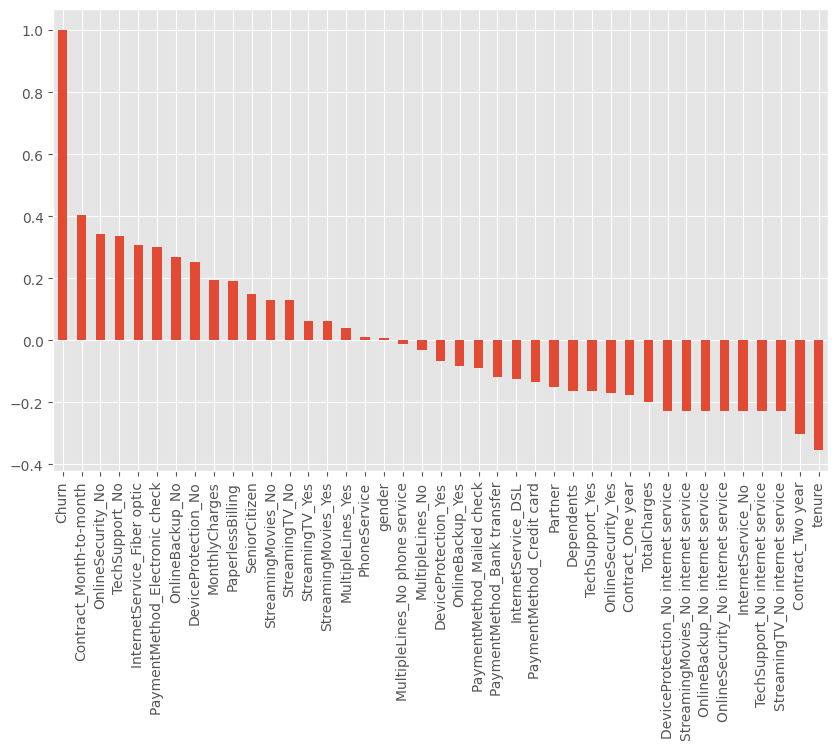

In [20]:
#Correlation Analysis
plt.figure(figsize=(10,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.savefig("correlation.png", dpi=300)
plt.show()

In [21]:
#Split data into features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

In [22]:
#Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('The number of records in the training dataset is', X_train.shape[0])
print('The number of records in the test dataset is', X_test.shape[0])

The number of records in the training dataset is 4922
The number of records in the test dataset is 2110


In [23]:
# Train the random forest model
rf = RandomForestClassifier()
baseline_model = rf.fit(X_train, y_train)

baseline_prediction = baseline_model.predict(X_test)
print(y_train.value_counts())

Churn
0    3614
1    1308
Name: count, dtype: int64


In [24]:
#Initialize Balancing Techniques: Oversampling
over = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over.fit_resample(X_train, y_train)
over_model = rf.fit(X_train_over, y_train_over)
over_prediction = over_model.predict(X_test)

#Check class distribution
print("Class distribution using Oversampler: ")
print(y_train_over.value_counts())

Class distribution using Oversampler: 
Churn
1    3614
0    3614
Name: count, dtype: int64


In [25]:
#Initialize Balancing Techniques: Undersampling
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
smote_model = rf.fit(X_train_smote, y_train_smote)
smote_prediction = smote_model.predict(X_test)
    
#Check class distribution
print("Class distribution using SMOTE: ")
print(y_train_smote.value_counts())

Class distribution using SMOTE: 
Churn
1    3614
0    3614
Name: count, dtype: int64


In [26]:
#Initialize Balancing Techniques: Undersampling
under = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
under_model = rf.fit(X_train_under, y_train_under)
under_prediction = under_model.predict(X_test)

#Check class distribution
print("Class distribution using Undersampling: ")
print(y_train_under.value_counts())

Class distribution using Undersampling: 
Churn
0    1308
1    1308
Name: count, dtype: int64


In [27]:
#Compare Techniques
print("No Sampling Technique")
print(classification_report(y_test, baseline_prediction))

print("Oversampling")
print(classification_report(y_test, over_prediction))

print("SMOTE")
print(classification_report(y_test, smote_prediction))

print("Undersampling")
print(classification_report(y_test, under_prediction))

No Sampling Technique
              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1549
           1       0.61      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.68      0.70      2110
weighted avg       0.77      0.78      0.77      2110

Oversampling
              precision    recall  f1-score   support

           0       0.84      0.85      0.85      1549
           1       0.57      0.57      0.57       561

    accuracy                           0.77      2110
   macro avg       0.71      0.71      0.71      2110
weighted avg       0.77      0.77      0.77      2110

SMOTE
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1549
           1       0.55      0.61      0.58       561

    accuracy                           0.76      2110
   macro avg       0.70      0.72      0.71      2110
weighted avg       0.77      0.76